In [7]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

# Recognize handwritten digits

## Task 1

In [2]:
digits = load_digits()
data = digits['images']
targets = digits['target']
labels = digits['target_names']

X, y = shuffle(data, targets, random_state=228)

X = X.reshape(X.shape[0], X.shape[1] ** 2)

## Task 2

In [3]:
def get_k_means(X, y, init_type='k-means++', n_clusters=10):
    k_means = KMeans(init=init_type, n_clusters=n_clusters)
    k_means.fit(X, y)
    return k_means

In [4]:
k_means_plus = KMeans(init='k-means++', n_clusters=10)
k_means_rand = KMeans(init='random', n_clusters=10)

k_means_plus = get_k_means(X, y, 'k-means++')
k_means_rand = get_k_means(X, y, 'random')

## Task 3

In [5]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

mean_clusters = k_means_plus.predict(X)
rand_clusters = k_means_rand.predict(X)


print 'Adjusted Mutual Information for k-means++ cluster: {0}'.format(adjusted_mutual_info_score(mean_clusters, y))
print 'Adjusted Mutual Information for random cluster: {0}'.format(adjusted_mutual_info_score(rand_clusters, y))
print '\n'
print 'Rand index adjusted score for k-means++ cluster: {0}'.format(adjusted_rand_score(mean_clusters, y))
print 'Rand index adjusted score for random cluster: {0}'.format(adjusted_rand_score(rand_clusters, y))

Adjusted Mutual Information for k-means++ cluster: 0.734320991261
Adjusted Mutual Information for random cluster: 0.734088420372


Rand index adjusted score for k-means++ cluster: 0.665135064347
Rand index adjusted score for random cluster: 0.663176468743


/Library/Python/2.7/site-packages/numpy/core/fromnumeric.py:2645: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


## Task 4

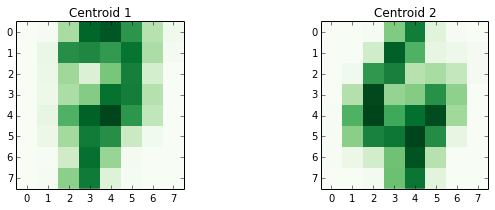

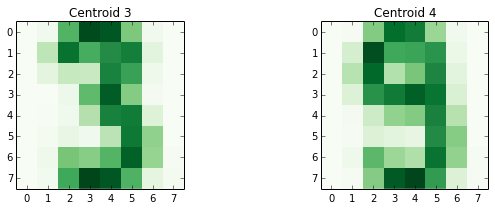

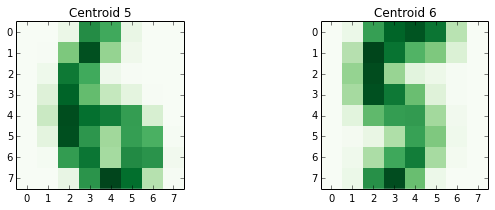

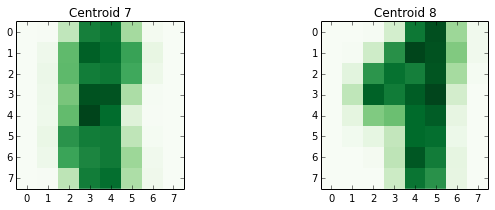

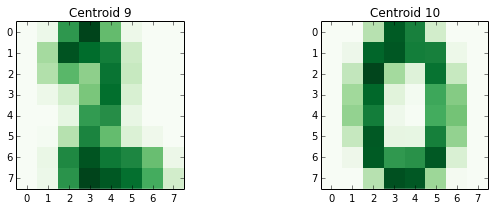

In [6]:
centers = k_means_plus.cluster_centers_

idx = 0

for i in range(5):
    fig = plt.figure(figsize=(10, 3))
    
    for j in range(2):
        a = fig.add_subplot(1, 2, j + 1)
        a.set_title('Centroid {0}'.format(idx + 1))
        plt.imshow(centers[idx].reshape(8, 8), interpolation='none', cmap=plt.cm.Greens)
        idx += 1

## Task 5

In [7]:
def get_popular_labels(clusters):
    lbls = []
    lbls_vals = []
    for label in labels:
        clusts = np.bincount(y[(clusters == label)])
        lbls.append(np.argsort(clusts)[::-1])
        lbls_vals.append(np.sort(clusts)[::-1])
        
    return lbls, lbls_vals

In [8]:
def plot_cluster_objects(clusters):
    labs, labs_vals = get_popular_labels(clusters)

    idx = 0


    for i in range(5):
        fig = plt.figure(figsize=(10, 3))

        for j in range(2):
            
            a = fig.add_subplot(1, 2, j + 1)
            a.set_xlabel('Classes')
            a.set_ylabel('Number of objects')
            
            a.set_xlim([0, 10])
            color = ''
            
            if abs(labs_vals[idx][0] - labs_vals[idx][1]) < 10:
                title = 'Cluster {0}. Class {1} or {2}'.format(idx + 1, labs[idx][0], labs[idx][1])
                color = 'r'
            else:
                title = 'Cluster {0}. Class {1}'.format(idx + 1, labs[idx][0])
                color = 'b'

            a.set_title(title)

            plt.bar(labs[idx], labs_vals[idx], color=color)
            idx += 1

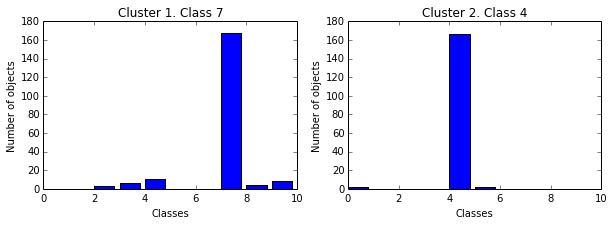

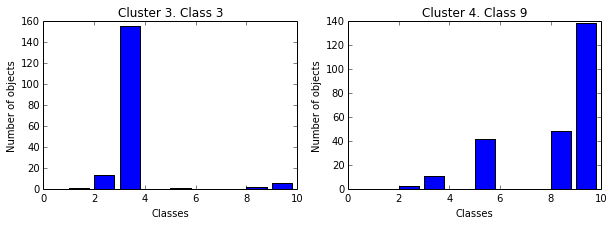

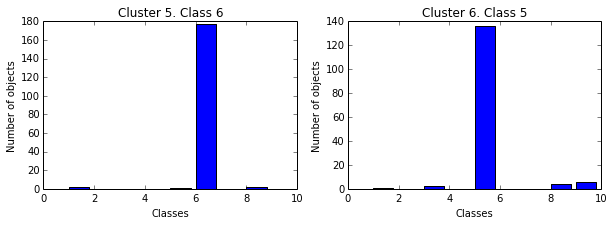

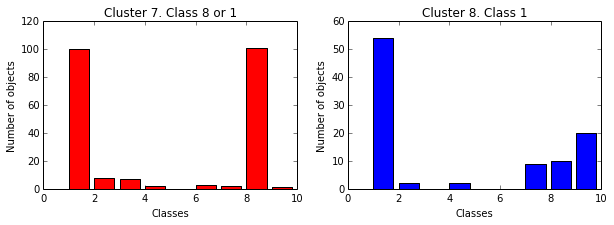

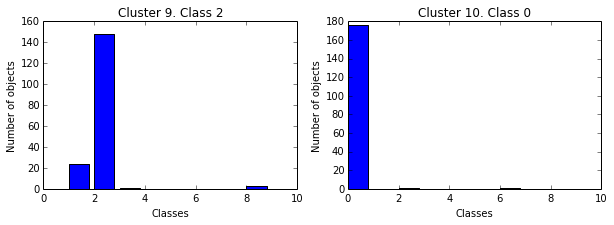

In [9]:
plot_cluster_objects(mean_clusters)

In [10]:
from collections import defaultdict

def nmi(x, y):
    def probs(X, Y=None):
        if Y is None:
            alphabet = np.unique(X)
            prs = defaultdict(float)
        else:
            alphabet = np.unique(Y)
            prs = defaultdict(dict)

        if Y is None:
            for x in X:
                prs[x] += 1 / float(X.size)
        else:
            for y in alphabet:
                X_filtered = X[(Y == y)]
                prs[y] = probs(X_filtered)

        return dict(prs)


    def entropy(X, Y=None):
        s = 0

        if Y is None:
            X_probs = probs(X)

            for p in X_probs.values():
                s += p * np.log(p)
        else:
            Y_probs = probs(Y)
            cond_probs = probs(X, Y)

            for y, values in cond_probs.iteritems():
                for val in values.values():
                    s += Y_probs[y] * val * np.log(val)
        return -s
    
    
    H_y = entropy(y)
    H_yx = entropy(y, x)
    
    return (H_y - H_yx) / H_y

In [11]:
nmis = np.array([nmi(X[:,i], y) for i in xrange(X.shape[1])])

<matplotlib.colorbar.Colorbar instance at 0x10752d998>

/Library/Python/2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


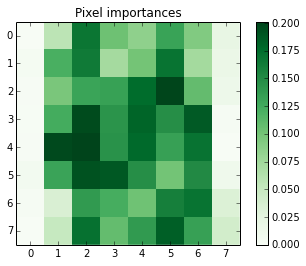

In [12]:
nmi_image = nmis.reshape((8, 8))


plt.title('Pixel importances')

plt.imshow(nmi_image, interpolation='none', cmap=plt.cm.Greens)
plt.colorbar()

In [13]:
nmis_idxs = np.argsort(nmis)[::-1]

mean_predictions = np.empty(len(nmis_idxs), dtype=object)
rand_predictions = np.empty(len(nmis_idxs), dtype=object)

scores = np.empty((len(nmis_idxs), 4), dtype=float)

for i in range(len(nmis_idxs)):
    selected_pixels = nmis_idxs[0:i + 1]
    
    X_new = X[:, selected_pixels]
    
    k_means = get_k_means(X_new, y)
    k_means_rand = get_k_means(X_new, y, init_type='random')
    
    mean_clusters = k_means.predict(X_new)
    rand_clusters = k_means_rand.predict(X_new)
    
    mean_predictions[i] = mean_clusters
    rand_predictions[i] = rand_clusters
    
    scores[i][0] = adjusted_mutual_info_score(mean_clusters, y)
    scores[i][1] = adjusted_mutual_info_score(rand_clusters, y)
    
    scores[i][2] = adjusted_rand_score(mean_clusters, y)
    scores[i][3] = adjusted_rand_score(rand_clusters, y)
    
    
    

In [14]:
print 'k-means++ best score, adjusted mutual info prediction: {0}'.format(scores[:,0].max())
print 'rand best score, adjusted mutual info prediction: {0}'.format(scores[:,1].max())
print '\n'
print 'k-means++ best score, randomly adjusted prediction: {0}'.format(scores[:,2].max())
print 'rand best score, randomly adjusted prediction: {0}'.format(scores[:,3].max())

k-means++ best score, adjusted mutual info prediction: 0.75134887203
rand best score, adjusted mutual info prediction: 0.75263610513


k-means++ best score, randomly adjusted prediction: 0.689812945392
rand best score, randomly adjusted prediction: 0.688162556789


Adjusted random score is low than Adjusted mutual score, so data is correlated. 
Scores do not change on metrics.

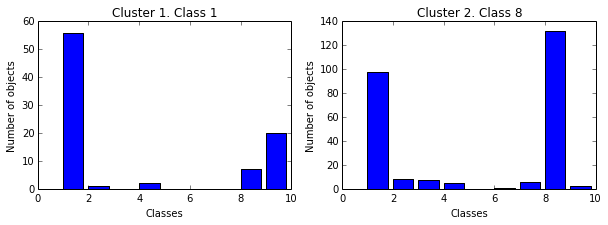

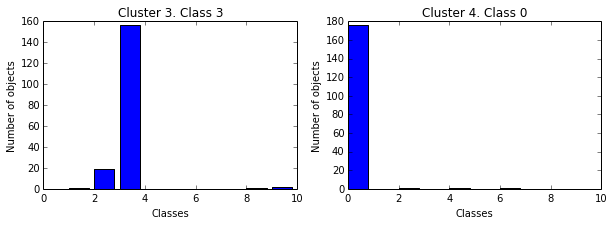

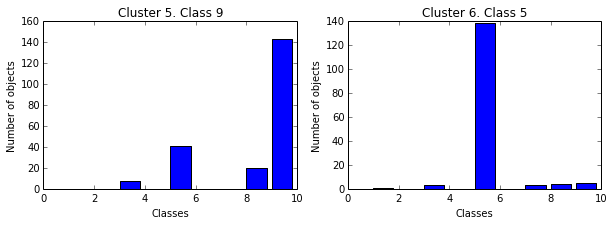

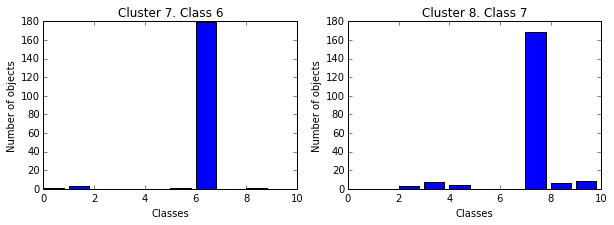

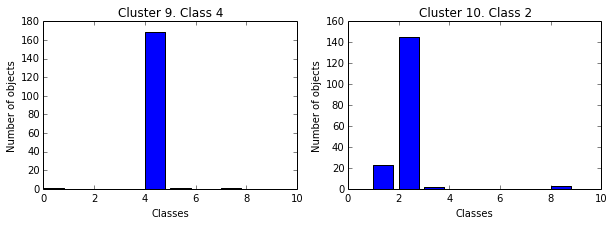

In [15]:
best_pixels = np.argmax(scores[:,0])
best_cluster = mean_predictions[best_pixels]

# selected_pixels = nmis_idxs[0:best_pixels]

# X_best = X[:, selected_pixels]

plot_cluster_objects(best_cluster)

# Limit the color pallet of the image with minimal loss in visual quality

## Task 1

In [5]:
from skimage.io import imread

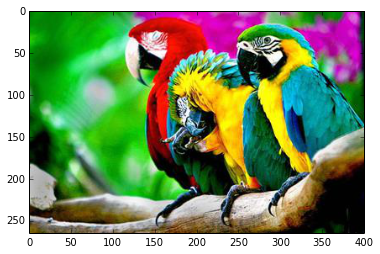

In [18]:
parrots = imread('parrots.jpg')
plt.imshow(parrots)

## Task 2 – 3

In [3]:
from sklearn.cluster import KMeans

In [31]:
K = (2, 3, 10, 20, 25, 30)

parrots_array = parrots.reshape(parrots.shape[0] * parrots.shape[1], parrots.shape[2])

clustered_parrots = []

for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(parrots_array)
    centers = k_means.cluster_centers_
    labels = k_means.labels_
    
    k_parrot = np.copy(parrots_array)
    
    for i in xrange(k):
        k_parrot[(labels == i)] = centers[i]
    
    clustered_parrots.append(k_parrot)

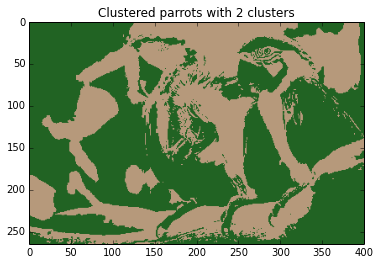

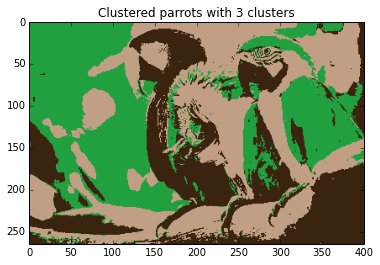

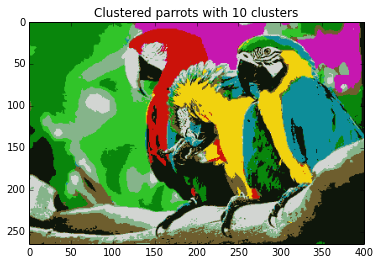

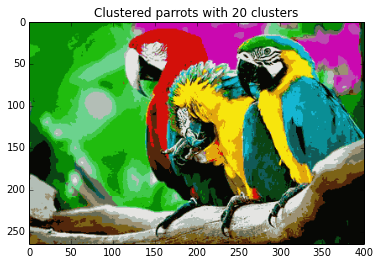

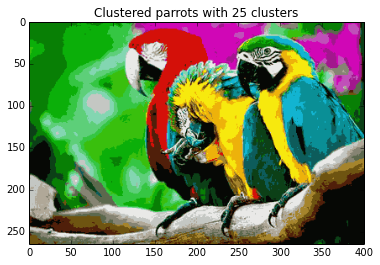

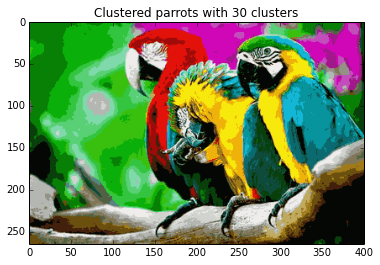

In [37]:
fig = 0

for k in K:
    fig += 1
    plt.figure(fig)
    
    plt.title('Clustered parrots with {0} clusters'.format(k))
    plt.imshow(clustered_parrots[fig - 1].reshape((265, 400, 3)))
    
    plt.show()

25 clusters look good enough

# Segment the image in semantic components

## Task 1

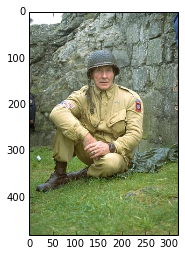

In [8]:
grass = imread('grass.jpg')
plt.imshow(grass)

## Task 2

In [95]:
new_grass = grass.reshape((grass.shape[0] * grass.shape[1], 3))

grass_array = np.zeros((grass.shape[0] * grass.shape[1], 5), dtype=int)
coordinates = np.mgrid[0:481, 0:321].reshape(2, -1).T

In [104]:
grass_array[:,[2, 3, 4]] = new_grass
grass_array[:,[0, 1]] = coordinates 

In [108]:
K = (2, 3, 5, 10, 20, 50)
L = (0.1, 0.5, 1, 2, 3, 5, 10)


grass_contours = []

for l in L:
    print 'Started clustering with L={0}'.format(l)
    l_arr = []
    grass_array[:,[0, 1]] = coordinates * l
    for k in K:
        print 'k={0} ...'.format(k)
        k_means = KMeans(n_clusters=k)
        k_means.fit(grass_array)
        l_arr.append(k_means.labels_)
    grass_contours.append(l_arr)
    print 'Finished'

Started clustering with L=0.1
k=2 ...
k=3 ...
k=5 ...
k=10 ...
k=20 ...
k=50 ...
Finished
Started clustering with L=0.5
k=2 ...
k=3 ...
k=5 ...
k=10 ...
k=20 ...
k=50 ...
Finished
Started clustering with L=1
k=2 ...
k=3 ...
k=5 ...
k=10 ...
k=20 ...
k=50 ...
Finished
Started clustering with L=2
k=2 ...
k=3 ...
k=5 ...
k=10 ...
k=20 ...
k=50 ...
Finished
Started clustering with L=3
k=2 ...
k=3 ...
k=5 ...
k=10 ...
k=20 ...
k=50 ...
Finished
Started clustering with L=5
k=2 ...
k=3 ...
k=5 ...
k=10 ...
k=20 ...
k=50 ...
Finished
Started clustering with L=10
k=2 ...
k=3 ...
k=5 ...
k=10 ...
k=20 ...
k=50 ...
Finished


## Task 3 – 4

In [187]:
def show_clustered_images(lambd):
    try:
        index = L.index(lambd)
    except ValueError:
        print 'This lambda is not defined'
        
    
    k_arr = grass_contours[index]

    
    for i in xrange(2):
        fig = plt.figure(figsize=(20, 5), dpi=80)
        for j in xrange(3):
            a = fig.add_subplot(1, 5, j + 1)
            
            current_k = i * 3 + j
            k = K[current_k]
            
            
            title = 'Clustered picture with {0} clusters'.format(k)
            a.set_title(title)
            
            labels = k_arr[current_k].reshape((grass.shape[0], grass.shape[1]))
            
            plt.imshow(grass)
            
            for l in range(k):
                try:
                    plt.contour(labels == l, contours=1, colors=[plt.cm.spectral(l / float(k)), ])
                except:
                    print 'In {0}-clustered image {1} label not exists'.format(k, l)

    plt.show()

### λ = 0.1

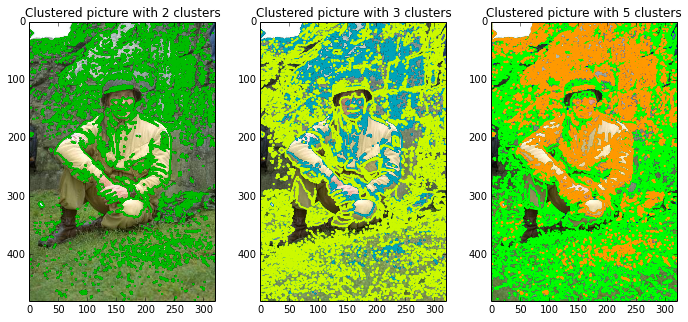

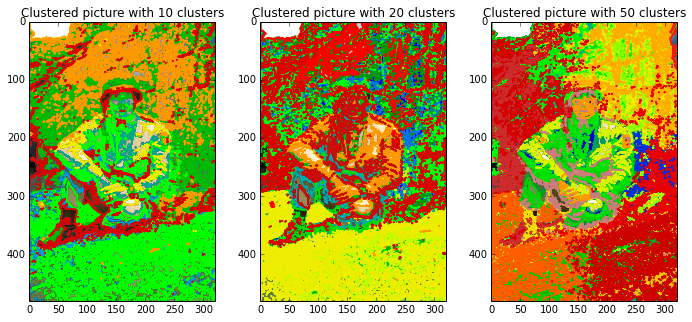

In [189]:
show_clustered_images(0.1)

### λ = 0.5

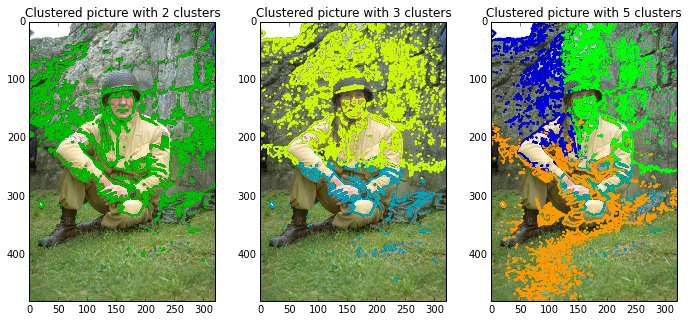

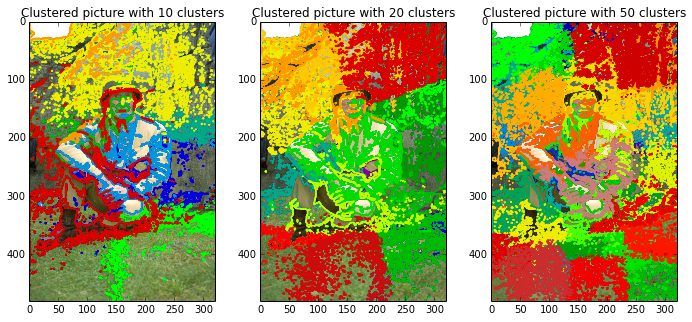

In [190]:
show_clustered_images(0.5)

### λ = 1.0

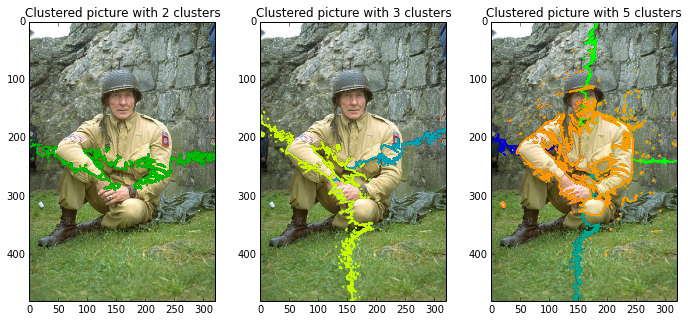

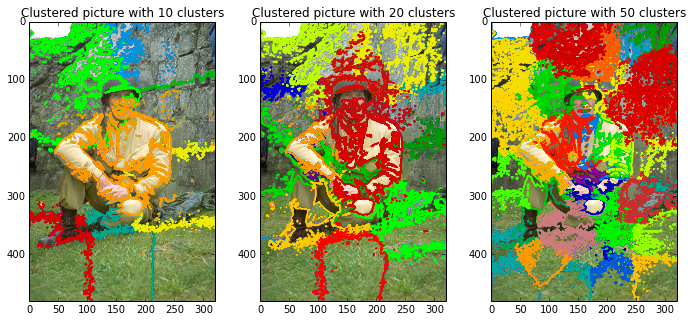

In [191]:
show_clustered_images(1)

### λ = 2.0

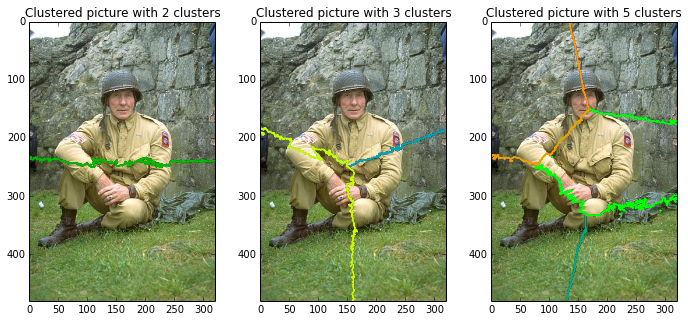

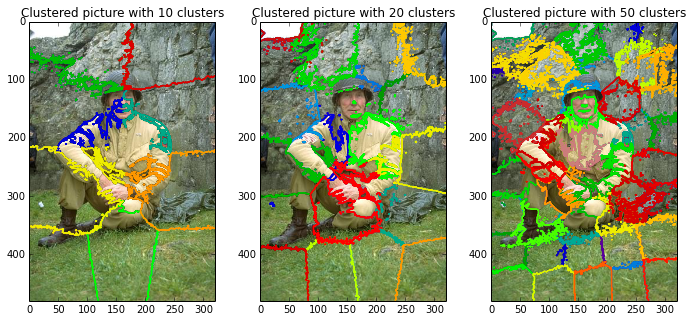

In [192]:
show_clustered_images(2)

### λ = 3.0

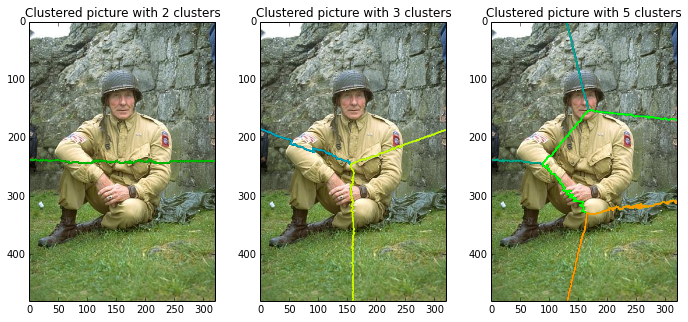

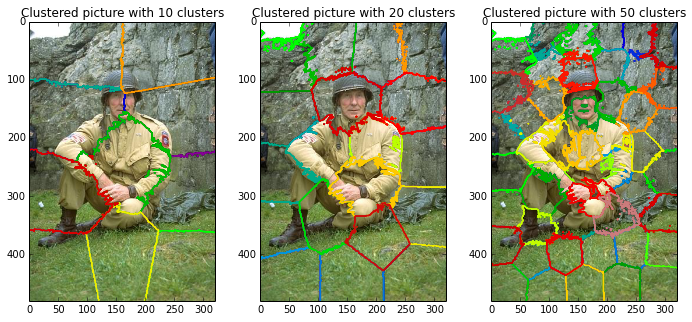

In [193]:
show_clustered_images(3)

### λ = 5.0

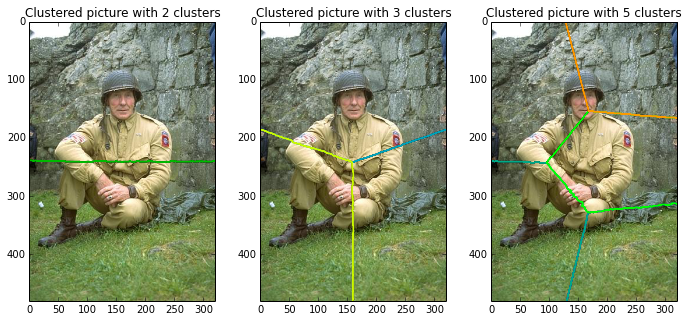

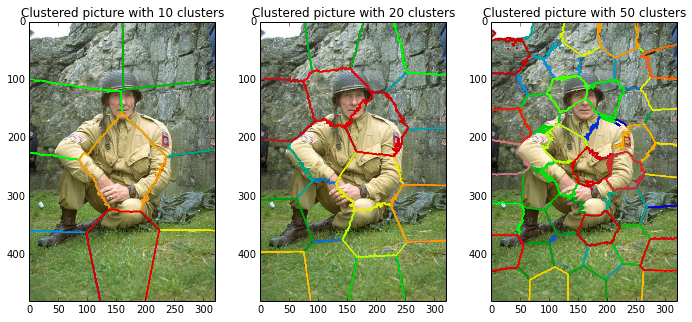

In [194]:
show_clustered_images(5)

### λ = 10.0

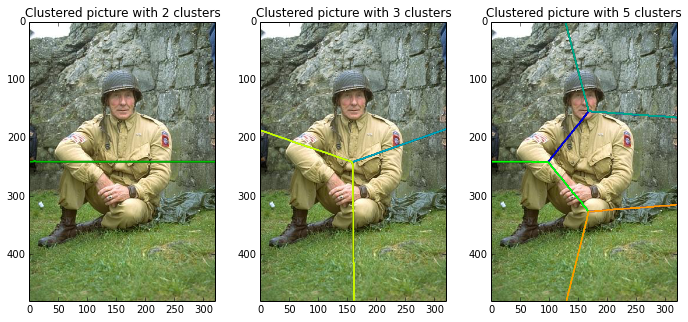

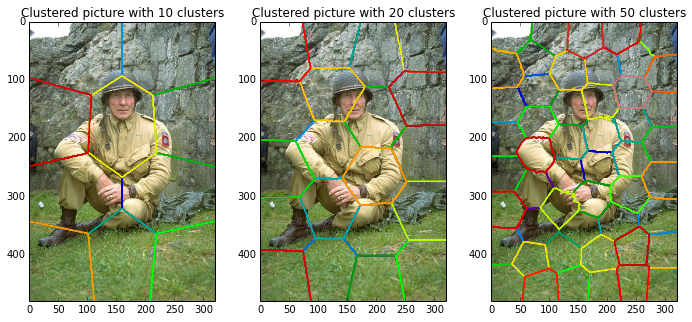

In [195]:
show_clustered_images(10)

Best segmentation is given by low lambda (0.1) and 5 clusters

## Task 5

In [10]:
from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

In [12]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [15]:
asl = ['kmeans', 'discretize']
K = [4, 7, 10, 15, 20, 40, 60]

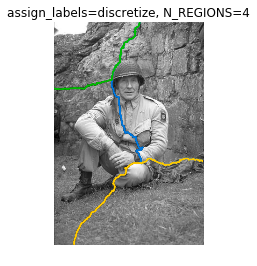

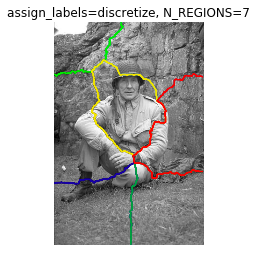

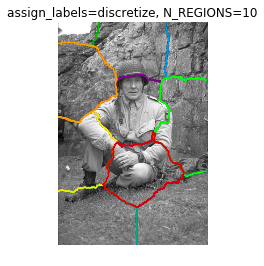

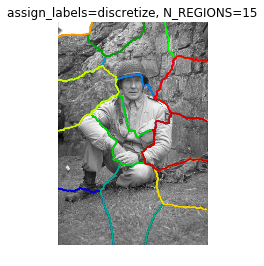

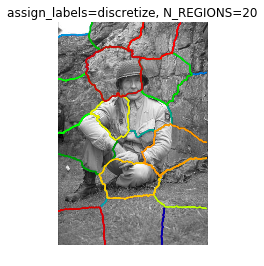

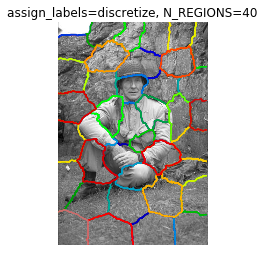

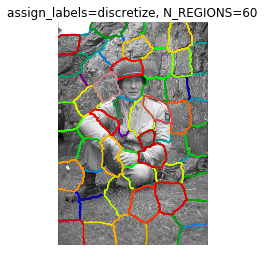

In [ ]:
grass_gs = rgb2gray(grass)
fignum = 0
for assign_labels in asl:
    for k in K:
        fignum += 1
        
        graph = image.img_to_graph(img)
        beta = 5
        eps = 1e-6
        graph.data = np.exp(-beta * graph.data / img.std()) + eps

        labels = spectral_clustering(graph, n_clusters=k, 
                                     assign_labels=assign_labels)
        labels = labels.reshape(img.shape)
        
        plt.figure(fignum)
        plt.title('assign_labels=%s, N_REGIONS=%s' % (assign_labels, 
                                                      k))
        plt.imshow(grass_gs, cmap=plt.cm.gray)
        for l in range(k):
            plt.contour(labels == l, contours=1,
                colors=[plt.cm.spectral(l / float(k)), ])
        plt.axis('off')
        plt.show()
        

Discretize works better, regions selected better (for example, helmet and face) are selected